In [1]:
import pandas as pd
import numpy as np
from datasets import load_dataset

# Load the dataset from Hugging Face
dataset = load_dataset("gtfintechlab/finer-ord")

# Convert each split to a DataFrame
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

In [2]:
dataset

DatasetDict({
    train: Dataset({
        features: ['gold_label', 'gold_token', 'doc_idx', 'sent_idx'],
        num_rows: 80531
    })
    validation: Dataset({
        features: ['gold_label', 'gold_token', 'doc_idx', 'sent_idx'],
        num_rows: 10233
    })
    test: Dataset({
        features: ['gold_label', 'gold_token', 'doc_idx', 'sent_idx'],
        num_rows: 25957
    })
})

### Currently, each row in the dataset contains: label, token, doc index, and sentence index.
### We need to group these tokens into sentences to be able to train our models on them with context.

In [3]:
def group_by_sentence(df):
    """
    Converts token-level DataFrame to sentence-level DataFrame where each row contains
    just the sentence tokens and corresponding labels.
    
    Args:
        df (pd.DataFrame): DataFrame with columns ['gold_label', 'gold_token', 'doc_idx', 'sent_idx']
    
    Returns:
        pd.DataFrame: DataFrame with columns ['tokens', 'labels']
    """
    # Convert None values to the string "None" in gold_token column
    df['gold_token'] = df['gold_token'].fillna("None")
    
    # Group by both document and sentence indices
    grouped = df.groupby(['doc_idx', 'sent_idx']).agg({
        'gold_token': list,
        'gold_label': list
    }).reset_index()
    
    # Keep only the relevant columns and rename them
    return grouped[['gold_token', 'gold_label']].rename(columns={
        'gold_token': 'words',
        'gold_label': 'labels'
    })

In [4]:
train_df = group_by_sentence(train_df)
val_df = group_by_sentence(val_df)
test_df = group_by_sentence(test_df)

In [5]:
train_df.head()

,words,labels
0,"[Kenyan, Firms, Eye, Deals, During, Obama, Sum...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[By, Neville, Otuki, Kenya, 's, business, lead...","[0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[Industrialists, ,, entrepreneurs, and, banker...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[More, on, This, Kenya, :, Mombasa, Road, ,, U...","[0, 0, 0, 3, 0, 3, 4, 0, 3, 4, 0, 3, 4, 4, 4, ..."
4,"["", Local, manufacturers, will, be, looking, f...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Exploring the data


Basic statistics:
Train - Mean: 24.7, Median: 23.0
Val   - Mean: 25.5, Median: 23.0
Test  - Mean: 24.1, Median: 23.0
Train - Max: 139.0, Min: 1.0
Val   - Max: 101.0, Min: 1.0
Test  - Max: 138.0, Min: 1.0

Very short sentences (length <= 2):
Train: 72 sentences
Val  : 7 sentences
Test : 23 sentences


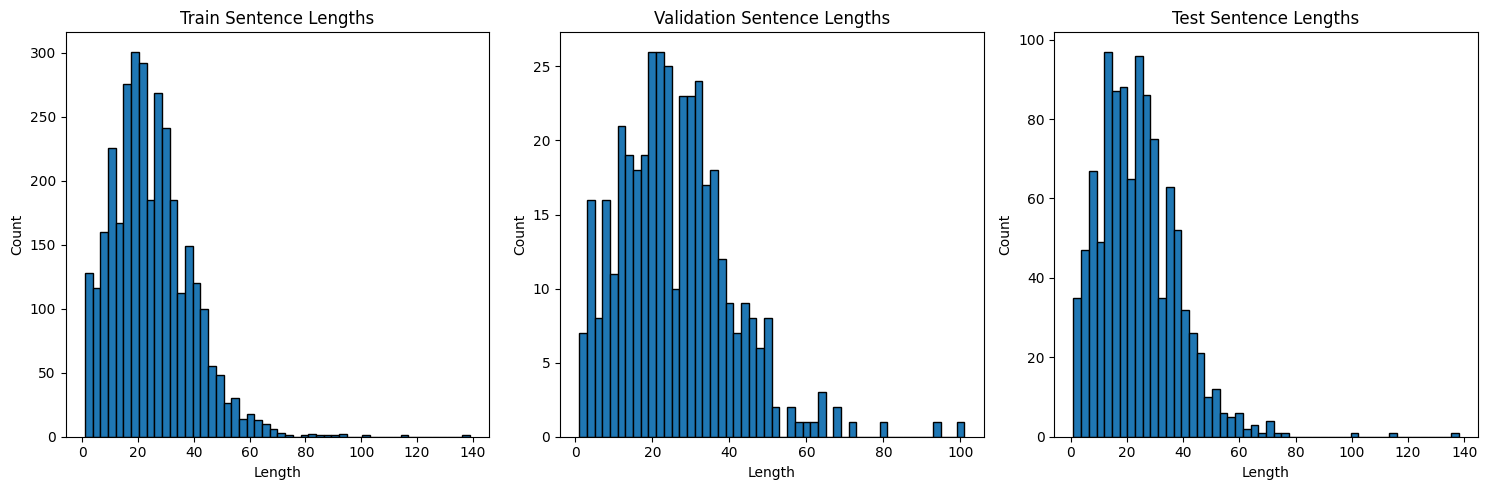

In [28]:
import matplotlib.pyplot as plt

def plot_sentence_lengths(train_df, val_df, test_df):
    """
    Creates histograms of sentence lengths for each dataset split.
    
    Args:
        train_df, val_df, test_df: DataFrames containing 'tokens' column
    """    
    
    # Create figure with three subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Calculate lengths for each dataset
    train_lengths = [len(tokens) for tokens in train_df['tokens']]
    val_lengths = [len(tokens) for tokens in val_df['tokens']]
    test_lengths = [len(tokens) for tokens in test_df['tokens']]
    
    # Plot histograms
    ax1.hist(train_lengths, bins=50, edgecolor='black')
    ax1.set_title('Train Sentence Lengths')
    ax1.set_xlabel('Length')
    ax1.set_ylabel('Count')
    
    ax2.hist(val_lengths, bins=50, edgecolor='black')
    ax2.set_title('Validation Sentence Lengths')
    ax2.set_xlabel('Length')
    ax2.set_ylabel('Count')
    
    ax3.hist(test_lengths, bins=50, edgecolor='black')
    ax3.set_title('Test Sentence Lengths')
    ax3.set_xlabel('Length')
    ax3.set_ylabel('Count')
    
    plt.tight_layout()
    
    # Print some basic statistics
    print("\nBasic statistics:")
    print(f"Train - Mean: {np.mean(train_lengths):.1f}, Median: {np.median(train_lengths):.1f}")
    print(f"Val   - Mean: {np.mean(val_lengths):.1f}, Median: {np.median(val_lengths):.1f}")
    print(f"Test  - Mean: {np.mean(test_lengths):.1f}, Median: {np.median(test_lengths):.1f}")
    print(f"Train - Max: {np.max(train_lengths):.1f}, Min: {np.min(train_lengths):.1f}")
    print(f"Val   - Max: {np.max(val_lengths):.1f}, Min: {np.min(val_lengths):.1f}")
    print(f"Test  - Max: {np.max(test_lengths):.1f}, Min: {np.min(test_lengths):.1f}")
    
    # Count very short sentences (length <= 2)
    print("\nVery short sentences (length <= 2):")
    print(f"Train: {sum(1 for x in train_lengths if x <= 2)} sentences")
    print(f"Val  : {sum(1 for x in val_lengths if x <= 2)} sentences")
    print(f"Test : {sum(1 for x in test_lengths if x <= 2)} sentences")

plot_sentence_lengths(train_df, val_df, test_df)

In [27]:
val_df[val_df['tokens'].apply(len) < 4]

,tokens,labels
1,"[Learn, more, ...]","[0, 0, 0]"
75,"[LOCAL, PAIN]","[0, 0]"
86,"[Play, video]","[0, 0]"
143,"[More, in, Moneylife]","[0, 0, 5]"
145,"[Learn, more, ...]","[0, 0, 0]"
191,"[Neither, Yahoo, !]","[0, 5, 6]"
197,"[Yahoo7, News, Network]","[5, 6, 6]"
199,"[Alex, Ellinghausen]","[1, 2]"
201,"[Queensland, Liberal, MP]","[3, 0, 0]"
249,"[Alex, Ellinghausen]","[1, 2]"


### Keeping the outlier short sentences
  
An argument could be made for removing these short sentence. But I think that in a real life scenario, working with real data scraped from the internet, we can expect to encounter such short sentences. These sentences are likely bullet points, headlines, table entries, etc...  So it is not a stretch to expect a well trained model to be able to correctly recognize these sentences and any entities inside them, even if they're only a few words long. Additionnally, the authors of the FiNER paper seem to have kept these sentences as well. 

### Approach 1: Fine-tuned BERT:

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForTokenClassification, AdamW
from sklearn.metrics import classification_report
import numpy as np
from tqdm import tqdm

# Constants
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5
MODEL_NAME = 'bert-base-cased'

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

In [7]:
class FinerDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=None):
        """
        Input:
        dataframe: a Pandas dataframe with 'words' (list of tokens) and 'labels' (list of NER tags)
        tokenizer: BertTokenizerFast instance
        max_length: maximum sequence length for truncation (if needed)
        """
        self.data = dataframe
        self.tokenized_inputs = []
        
        # Tokenize all sentences
        for _, row in self.data.iterrows():
            # Tokenize the input
            tokens = tokenizer(
                row['words'],
                is_split_into_words=True,
                truncation=True if max_length else False,
                max_length=max_length,
            )
            tokens.pop('token_type_ids')
            
            # Get word IDs and align labels
            word_ids = tokens.word_ids()
            aligned_labels = self._align_labels(row['labels'], word_ids)
            
            # Store tokenized input with aligned labels
            tokens['labels'] = aligned_labels
            self.tokenized_inputs.append(tokens)

    def __getitem__(self, index):
        """Return the dictionary of inputs at the specified index"""
        return self.tokenized_inputs[index]
    
    def __len__(self):
        return len(self.tokenized_inputs)

    def _align_labels(self, labels, word_ids):
        # Define a mapping from beginning (B-) labels to inside (I-) labels
        begin2inside = {
            1: 2,  # B-PER -> I-PER
            3: 4,  # B-LOC -> I-LOC
            5: 6,  # B-ORG -> I-ORG
        }
    
        # Initialize an empty list to store aligned labels and a variable to track the last word
        aligned_labels = []
        last_word = None
    
        # Iterate through the word_ids
        for word in word_ids:
            if word is None:
                label = -100  # Set label to -100 for None word_ids
            elif word != last_word:
                label = labels[word]  # Use the label corresponding to the current word_id
            else:
                label = labels[word]
                # Change B- to I- if the previous word is the same
                if label in begin2inside:
                    label = begin2inside[label]  # Map B- to I-
    
            # Append the label to the align_labels list and update last_word
            aligned_labels.append(label)
            last_word = word
    
        return aligned_labels

In [8]:
from transformers import DataCollatorForTokenClassification

# Initialize datasets
train_dataset = FinerDataset(train_df, tokenizer)
val_dataset = FinerDataset(val_df, tokenizer)
test_dataset = FinerDataset(test_df, tokenizer)

# Initialize data collator
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True,
)

In [9]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

# Create data loaders
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers,
    collate_fn=data_collator,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers,
    collate_fn=data_collator,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=num_workers,
    collate_fn=data_collator,
    drop_last=False
)

In [10]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

407 training batches
51 validation batches
135 test batches


In [12]:
# Get the first batch
first_batch = next(iter(train_loader))

# First batch is a dictionary with keys like 'input_ids', 'attention_mask', 'labels'
# Each value is a tensor of shape (batch_size, sequence_length)
print("First batch keys:", first_batch.keys())
print("\nShapes:")
for key, value in first_batch.items():
    print(f"{key}: {value.shape}")

# To see the first item in the batch
first_item = {key: value[0] for key, value in first_batch.items()}
print("\nFirst item in batch:")
for key, value in first_item.items():
    print(f"\n{key}:", value)

# If you want to see the actual tokens, you can decode the input_ids
print("\nDecoded tokens:")
print(tokenizer.decode(first_item['input_ids']))

First batch keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

Shapes:
input_ids: torch.Size([8, 46])
token_type_ids: torch.Size([8, 46])
attention_mask: torch.Size([8, 46])
labels: torch.Size([8, 46])

First item in batch:

input_ids: tensor([  101,   138,  1249,  9388,  1398, 13335,  1891,  6606,  1116,  1132,
         1111,  1343,  9660,  1150,  1328,  1106,  1321,  1126,  7401,  1154,
         1472, 13274,  3553,  1133,  1202,  1136,  3683,  1106,  2561,  1147,
         1319,   119,   119,   119,   154,   146,  1821,   170,  2682,  7888,
          119,   102,     0,     0,     0,     0])

token_type_ids: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

labels: tensor([-100,    0,  

### Training and evaluation

In [88]:
from torch.optim import AdamW 
model = BertForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=7,  # O, PER_B, PER_I, LOC_B, LOC_I, ORG_B, ORG_I
)


optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

def compute_metrics(predictions, labels):
    def parse_classification_report(cr):
        out = {
            'PER_f1': None,
            'LOC_f1': None,
            'ORG_f1': None
        }
        arr = cr.split('\n')
        arr = [a.split() for a in arr if a.strip()]
        for a in arr:
            if a[0] in ['PER', 'LOC', 'ORG']:
                out[f'{a[0]}_f1'] = a[3]
        out['weighted_avg_f1'] = arr[-1][3]
        return out
    # Convert numeric labels to BIO tags
    id2label = {
        0: 'O',
        1: 'B-PER', 2: 'I-PER',
        3: 'B-LOC', 4: 'I-LOC',
        5: 'B-ORG', 6: 'I-ORG'
    }
    
    # predictions is a list of arrays, each containing logits for one sequence
    # Convert logits to tag indices
    pred_tags = []
    true_tags = []
    
    # Process each sequence
    for pred_logits, label_ids in zip(predictions, labels):
        # Convert logits to tag indices for this sequence
        pred_ids = np.argmax(pred_logits, axis=-1)
        
        # Convert IDs to tag names
        pred_tags.append([id2label[p] for p in pred_ids])
        true_tags.append([id2label[l] for l in label_ids])
    

    # Calculate weighted average
    cr = classification_report(true_tags, pred_tags, mode='strict', scheme=IOB2)
    
    return parse_classification_report(cr)

In [30]:
def evaluate_model(model, dataloader, device, num_batches=None):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if num_batches and i >= num_batches:
                break
                
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass
            outputs = model(**batch)
            total_loss += outputs.loss.item()
            
            # Get predictions for this batch
            predictions = outputs.logits.cpu().numpy()
            labels = batch['labels'].cpu().numpy()
            masks = batch['attention_mask'].cpu().numpy()
            
            # For each sequence in the batch
            for pred, label, mask in zip(predictions, labels, masks):
                # Get valid indices
                valid_indices = (mask.astype(bool)) & (label != -100)
                all_predictions.append(pred[valid_indices])
                all_labels.append(label[valid_indices])
    
    # Calculate average loss
    avg_loss = total_loss / (num_batches if num_batches else len(dataloader))
    
    metrics = compute_metrics(all_predictions, all_labels)
    metrics['loss'] = avg_loss
    
    return metrics

In [86]:
# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set model to eval mode
model.eval()

# Test the evaluate_model function
print("Testing model evaluation before training...")
initial_metrics = evaluate_model(
    model=model,
    dataloader=test_loader,
    device=device,
    num_batches=25  # Only evaluate on limited batches for quick testing
)

# Print results
print("\nInitial Metrics:")
for metric_name, value in initial_metrics.items():
    print(f"{metric_name}: {value}")

Testing model evaluation before training...

Initial Metrics:
PER_f1: 0.01
LOC_f1: 0.03
ORG_f1: 0.00
weighted_avg_f1: 0.06
loss: 1.8749789333343505


In [28]:
def train_classifier(model, train_loader, val_loader, optimizer, device, num_epochs,
                    eval_freq, eval_iter):
    # Initialize lists to track losses and F1
    train_losses, val_losses = [], []
    train_f1s, val_f1s = [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for batch in train_loader:
            # Move all batch elements to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss  # BERT models return loss directly
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            examples_seen += batch['input_ids'].shape[0]
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_metrics = evaluate_model(
                    model, train_loader, device, eval_iter)
                val_metrics = evaluate_model(
                    model, val_loader, device, eval_iter)
                
                train_losses.append(train_metrics['loss'])
                val_losses.append(val_metrics['loss'])
                train_f1s.append(train_metrics['weighted_avg_f1'])
                val_f1s.append(val_metrics['weighted_avg_f1'])
                
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_metrics['loss']:.3f}, Val loss {val_metrics['loss']:.3f}\n"
                      f"Train F1 {train_metrics['weighted_avg_f1']:.3f}, Val F1 {val_metrics['weighted_avg_f1']:.3f}")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'examples_seen': examples_seen
    }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

metrics = train_classifier(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=5,
    eval_freq=50,
    #eval_iter=50
)

# Plot training curves
plt.plot(metrics['train_losses'], label='Train Loss')
plt.plot(metrics['val_losses'], label='Val Loss')
plt.legend()
plt.show()